<a href="https://colab.research.google.com/github/talentkulkat-art/textual-todo/blob/main/Telecom%20Customer%20Targeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(cm, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["No", "Yes"])
    plt.yticks(tick_marks, ["No", "Yes"])

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


In [2]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt


In [3]:
from google.colab import files

uploaded = files.upload()


Saving wallacecommunications.csv to wallacecommunications.csv


In [4]:

df = pd.read_csv("wallacecommunications.csv")


print("Shape:", df.shape)
df.head()


Shape: (50662, 20)


,ID,town,country,age,job,married,education,arrears,current_balance,housing,has_tv_package,last_contact,conn_tr,last_contact_this_campaign_day,last_contact_this_campaign_month,this_campaign,days_since_last_contact_previous_campaign,contacted_during_previous_campaign,outcome_previous_campaign,new_contract_this_campaign
0,32390233,Bristol,UK,39,management,married,tertiary,no,-1.90,no,yes,unknown,4,11,jun,8,-1,0,unknown,yes
1,41226029,Basildon,UK,53,housemaid,married,primary,no,3.62,no,no,cellular,1,28,jul,2,-1,0,unknown,yes
2,85498057,Blackburn,UK,79,retired,divorced,primary,no,27.87,no,no,telephone,3,13,jul,1,377,1,success,yes
3,76539627,Oldham,UK,43,services,single,secondary,no,5.50,yes,no,cellular,3,13,may,2,-1,0,unknown,no
4,76290986,Middlesbrough,UK,35,technician,single,secondary,no,3.44,no,no,cellular,2,27,aug,16,-1,0,unknown,yes


In [5]:
# i will drop ID because it's just an identifier and not useful for prediction
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

target_col = "new_contract_this_campaign"

# Features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True))  # to see imbalance


Features shape: (50662, 18)
Target distribution:
new_contract_this_campaign
no     40763
yes     9899
Name: count, dtype: int64
new_contract_this_campaign
no     0.804607
yes    0.195393
Name: proportion, dtype: float64


In [6]:
# This is the first split: train vs (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)


Train shape: (30397, 18)
Val shape:   (10132, 18)
Test shape:  (10133, 18)


In [7]:
# Numeric features : continuous / discrete)
numeric_features = [
    "age",
    "current_balance",
    "conn_tr",
    "last_contact_this_campaign_day",
    "this_campaign",
    "days_since_last_contact_previous_campaign",
    "contacted_during_previous_campaign"
]

# Categorical features
categorical_features = [
    "town",
    "country",
    "job",
    "married",
    "education",
    "arrears",
    "housing",
    "has_tv_package",
    "last_contact",
    "last_contact_this_campaign_month",
    "outcome_previous_campaign"
]


In [8]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [9]:
#  Model 1 Logistic Regression


log_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# Tiny hyperparameter search
log_param_grid = {
    "model__C": [0.1, 1.0, 10.0]
}

log_search = GridSearchCV(
    estimator=log_pipe,
    param_grid=log_param_grid,
    scoring="f1",      # focus on F1 for the 'yes' class
    cv=3,
    n_jobs=-1
)

log_search.fit(X_train, y_train)

print("Best Logistic Regression params:", log_search.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best Logistic Regression params: {'model__C': 0.1}


=== Logistic Regression (Validation) ===
              precision    recall  f1-score   support

          no       0.84      0.97      0.90      8152
         yes       0.71      0.26      0.38      1980

    accuracy                           0.83     10132
   macro avg       0.78      0.62      0.64     10132
weighted avg       0.82      0.83      0.80     10132

=== Logistic Regression (Test) ===
              precision    recall  f1-score   support

          no       0.85      0.97      0.91      8153
         yes       0.71      0.28      0.40      1980

    accuracy                           0.84     10133
   macro avg       0.78      0.63      0.65     10133
weighted avg       0.82      0.84      0.81     10133

Confusion matrix (Logistic Regression, test):
[[7928  225]
 [1424  556]]


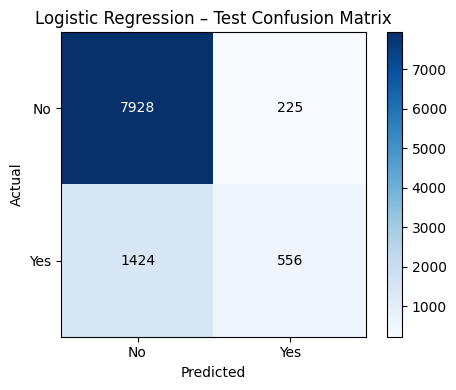

In [10]:
log_best = log_search.best_estimator_

# Validation performance (for model selection)
y_val_log = log_best.predict(X_val)
print("=== Logistic Regression (Validation) ===")
print(classification_report(y_val, y_val_log))

# Test performance (final check)
y_test_log = log_best.predict(X_test)
print("=== Logistic Regression (Test) ===")
print(classification_report(y_test, y_test_log))

cm_log = confusion_matrix(y_test, y_test_log, labels=["no", "yes"])
print("Confusion matrix (Logistic Regression, test):")
print(cm_log)
plot_confusion(cm_log, "Logistic Regression – Test Confusion Matrix")


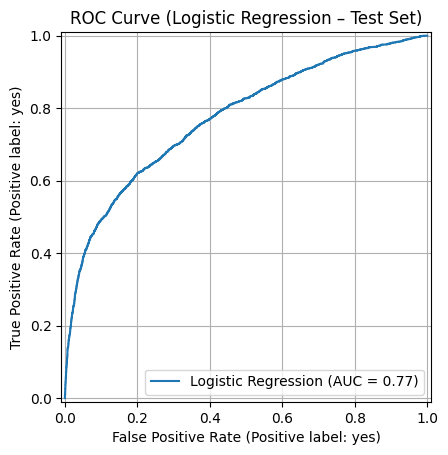

In [18]:
from sklearn.metrics import RocCurveDisplay

y_test_proba_log = log_best.predict_proba(X_test)[:, 1]

# ROC curve
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba_log,
    pos_label="yes",
    name="Logistic Regression"
)

plt.title("ROC Curve (Logistic Regression – Test Set)")
plt.grid(True)
plt.show()


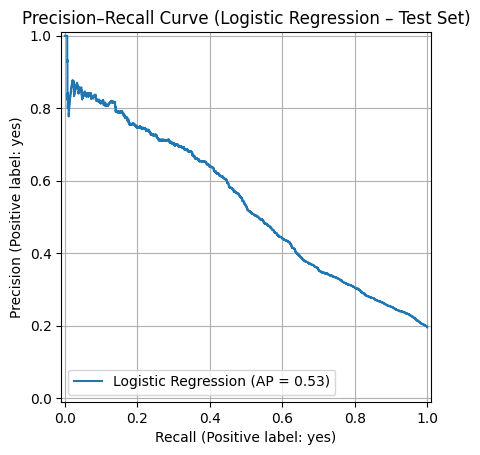

In [19]:
from sklearn.metrics import PrecisionRecallDisplay


PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba_log,
    pos_label="yes",
    name="Logistic Regression"
)

plt.title("Precision–Recall Curve (Logistic Regression – Test Set)")
plt.grid(True)
plt.show()


In [11]:
# Model 2: Random Forest

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_param_dist = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)

print("Best Random Forest params:", rf_search.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Random Forest params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 10}


=== Random Forest (Validation) ===
              precision    recall  f1-score   support

          no       0.83      0.99      0.91      8152
         yes       0.81      0.19      0.31      1980

    accuracy                           0.83     10132
   macro avg       0.82      0.59      0.61     10132
weighted avg       0.83      0.83      0.79     10132

=== Random Forest (Test) ===
              precision    recall  f1-score   support

          no       0.84      0.99      0.91      8153
         yes       0.79      0.21      0.33      1980

    accuracy                           0.83     10133
   macro avg       0.81      0.60      0.62     10133
weighted avg       0.83      0.83      0.79     10133

Confusion matrix (Random Forest, test):
[[8042  111]
 [1564  416]]


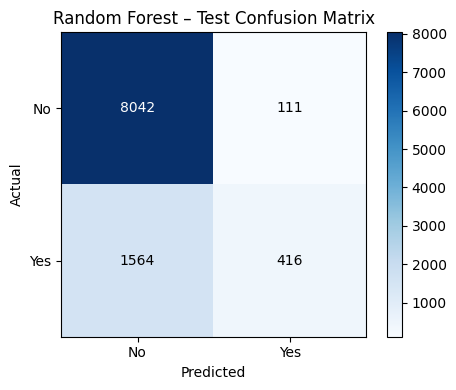

In [12]:
rf_best = rf_search.best_estimator_

# Validation performance
y_val_rf = rf_best.predict(X_val)
print("=== Random Forest (Validation) ===")
print(classification_report(y_val, y_val_rf))

# Test performance
y_test_rf = rf_best.predict(X_test)
print("=== Random Forest (Test) ===")
print(classification_report(y_test, y_test_rf))

cm_rf = confusion_matrix(y_test, y_test_rf, labels=["no", "yes"])
print("Confusion matrix (Random Forest, test):")
print(cm_rf)
plot_confusion(cm_rf, "Random Forest – Test Confusion Matrix")


In [13]:
# Model 3 Gradient Boosting

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5]
}

gb_search = GridSearchCV(
    estimator=gb_pipe,
    param_grid=gb_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)

print("Best Gradient Boosting params:", gb_search.best_params_)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Gradient Boosting params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


=== Gradient Boosting (Validation) ===
              precision    recall  f1-score   support

          no       0.84      0.98      0.91      8152
         yes       0.73      0.25      0.37      1980

    accuracy                           0.84     10132
   macro avg       0.79      0.61      0.64     10132
weighted avg       0.82      0.84      0.80     10132

=== Gradient Boosting (Test) ===
              precision    recall  f1-score   support

          no       0.84      0.97      0.90      8153
         yes       0.71      0.26      0.38      1980

    accuracy                           0.83     10133
   macro avg       0.78      0.62      0.64     10133
weighted avg       0.82      0.83      0.80     10133

Confusion matrix (Gradient Boosting, test):
[[7943  210]
 [1465  515]]


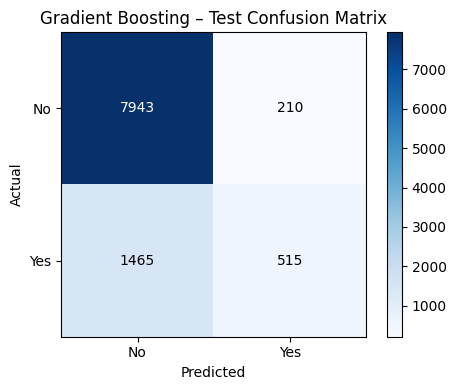

In [14]:
gb_best = gb_search.best_estimator_

# Validation performance
y_val_gb = gb_best.predict(X_val)
print("=== Gradient Boosting (Validation) ===")
print(classification_report(y_val, y_val_gb))

# Test performance
y_test_gb = gb_best.predict(X_test)
print("=== Gradient Boosting (Test) ===")
print(classification_report(y_test, y_test_gb))

cm_gb = confusion_matrix(y_test, y_test_gb, labels=["no", "yes"])
print("Confusion matrix (Gradient Boosting, test):")
print(cm_gb)
plot_confusion(cm_gb, "Gradient Boosting – Test Confusion Matrix")


In [15]:

test_predictions = {
    "Logistic Regression": y_test_log,
    "Random Forest": y_test_rf,
    "Gradient Boosting": y_test_gb
}

test_results = []

for model_name, y_pred in test_predictions.items():
    result = {
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, pos_label="yes"),
        "recall": recall_score(y_test, y_pred, pos_label="yes"),
        "f1": f1_score(y_test, y_pred, pos_label="yes")
    }

    test_results.append(result)


test_df = pd.DataFrame(test_results)
test_df


,model,accuracy,precision,recall,f1
0,Logistic Regression,0.837264,0.711908,0.280808,0.402753
1,Random Forest,0.834699,0.789374,0.210101,0.331871
2,Gradient Boosting,0.834699,0.710345,0.260101,0.380776
